# Bayes Opt + hyperparameter optimization

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.gpytorch import GPyTorchModel
from IPython.display import clear_output


In [17]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(GPyTorchModel, gpytorch.models.ExactGP):
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        # super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        super().__init__(train_x.reshape(-1), train_y.reshape(-1), likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        # self.covar_module = gpytorch.kernels.RBFKernel()
        # self.covar_module.lengthscale = 0.4
        self.to(train_x)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [18]:
def plot_bayes():
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        ax = plt.subplot(2,1,1)
        observed_pred = likelihood(model(test_x))
        lower, upper = observed_pred.confidence_region()
        test_y = f(test_x)
        ax.plot(test_x, test_y, '--k', lw=0.5)
        ax.plot(train_x, train_y, 'r*')
        ax.plot(test_x, observed_pred.mean, 'b')
        ax.fill_between(test_x, lower, upper, alpha=0.5)
        
        ax.set_ylim([test_y.min() - (test_y.max() - test_y.min())*.5, test_y.max() + (test_y.max() - test_y.min())*.5])
        # ax.legend(['Observed Data', 'Mean', 'Confidence', 'Ground truth'])
        plt.xlim(-0.01,1.01)
        plt.subplot(2,1,2)
        plt.plot(test_x, ei)
        plt.xlim(-0.01,1.01)

In [19]:
def train_hyper_params(model, likelihood, training_iter=20, verbose=False):
# Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

In [20]:
def f(x):
    # underlying true function to sample
    return (torch.sin(x * (2 * math.pi)) + torch.sin(x * (6 * math.pi))**3)

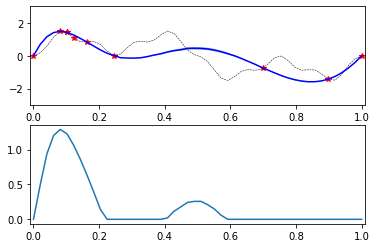

In [22]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0.0,1e-14))
test_x = torch.linspace(0,1,50)
train_x = torch.tensor([0.7])
train_y = f(train_x)

while len(train_x)<2 or (train_x[-1] - train_x[-2]).abs()>1e-6:
    model = ExactGPModel(train_x, train_y, likelihood)
    train_hyper_params(model, likelihood)
    EI = ExpectedImprovement(model, best_f=0.2)
    ei = EI(test_x.reshape(-1,1,1))
    x_new = test_x[ei.argmax().item()]
    clear_output(wait=True)
    plot_bayes()
    plt.pause(0.5)
    train_x = torch.cat((train_x.reshape(-1,1), x_new.reshape(-1,1))).reshape(-1)
    train_y = torch.cat((train_y.reshape(-1,1), f(x_new).reshape(-1,1))).reshape(-1)